<a href="https://colab.research.google.com/github/DavideBruni/CIDL_lab/blob/main/Lecture2/Exercises.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Es 1**

In [ ]:
import torch
import torchvision


train_mnist = torchvision.datasets.MNIST(
    "./data",
    train=True,
    download=True,
    transform=torchvision.transforms.Compose([
        torchvision.transforms.ToTensor(),
        torchvision.transforms.Normalize((0.1307,), (0.3081,))
    ])
)

test_mnist = torchvision.datasets.MNIST(
    "./data",
    train=False,
    download=True,
    transform=torchvision.transforms.Compose([
        torchvision.transforms.ToTensor(),
        torchvision.transforms.Normalize((0.1307,), (0.3081,))
    ])
)

In [ ]:
model = torch.nn.Sequential(
    torch.nn.Conv2d(1,32,(5,5),padding=1, stride=2),
    torch.nn.LeakyReLU(),
    torch.nn.Conv2d(32,64,(3,3),stride=3),
    torch.nn.LeakyReLU(),
    torch.nn.Conv2d(64,64,(3,3)),
    torch.nn.LeakyReLU(),
    torch.nn.Flatten(),
    torch.nn.Linear(256, 300),
    torch.nn.LeakyReLU(),
    torch.nn.Linear(300 ,300),
    torch.nn.LeakyReLU(),
    torch.nn.Linear(300, 10),
    torch.nn.Softmax(dim=1)
)

In [ ]:
from tqdm import tqdm

dl = torch.utils.data.DataLoader(train_mnist, batch_size=32, shuffle=True)
loss_fn = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

model = model.to("cuda")

for epoch in range(3):
    bar = tqdm(dl)
    for digit, classes in bar:
        digit = digit.to("cuda")
        classes = classes.to("cuda")

        pred = model(digit)
        loss = loss_fn(pred, classes)

        acc = (pred.argmax(dim=1) == classes).float().mean()

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        bar.set_description(f"loss: {loss.item():.2f}  acc: {acc.item():.2f}")




loss: 1.65  acc: 0.81:  15%|█▍        | 275/1875 [00:03<00:20, 79.71it/s]


KeyboardInterrupt: 

In [ ]:
import torch.nn.functional as F

correct = 0
total = 0
model.eval()

test_loader = torch.utils.data.DataLoader(test_mnist, batch_size=32, shuffle=True)
with torch.no_grad():
    for images, labels in test_loader:
        images = images.to("cuda")    #move to GPU!
        labels = labels.to("cuda")

        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

accuracy = correct / total
print(f'Accuracy on the test set: {accuracy * 100:.2f}%')

I mean... https://www.youtube.com/watch?v=iR9uEja0dOc&t=6s

# **Es 2**

In [ ]:
class OneHotNumbers(torch.utils.data.Dataset):
    def __init__(self, dataset):
        super().__init__()
        self.dataset = dataset

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        data, target = self.dataset[idx]
        one_hot = torch.zeros(10)
        one_hot[target] = 1

        return data, one_hot

torch.Size([10])
tensor([0., 0., 0., 1., 0., 0., 0., 0., 0., 0.])


In [ ]:
class GenerativeModel(torch.nn.Module):
    def __init__(self):
        super().__init__()

        self.model = torch.nn.Sequential(
            torch.nn.Linear(10, 300),
            torch.nn.LeakyReLU(),
            torch.nn.Linear(300, 300),
            torch.nn.LeakyReLU(),
            torch.nn.Linear(300, 28*28),
        )

    def forward(self, x):
        return self.model(x).reshape(-1, 1, 28, 28)

In [ ]:
from tqdm import tqdm

ds = OneHotNumbers(train_mnist)
dl = torch.utils.data.DataLoader(ds, batch_size=32, shuffle=True)
model = GenerativeModel()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
loss_fn = torch.nn.MSELoss()

for epoch in range(3):
    bar = tqdm(dl)
    for target, oh in bar:
        pred = model(oh)

        loss = loss_fn(pred, target)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        bar.set_description(f"Loss: {loss.item():.3f}")

Loss: 0.562: 100%|██████████| 1875/1875 [00:27<00:00, 68.21it/s]


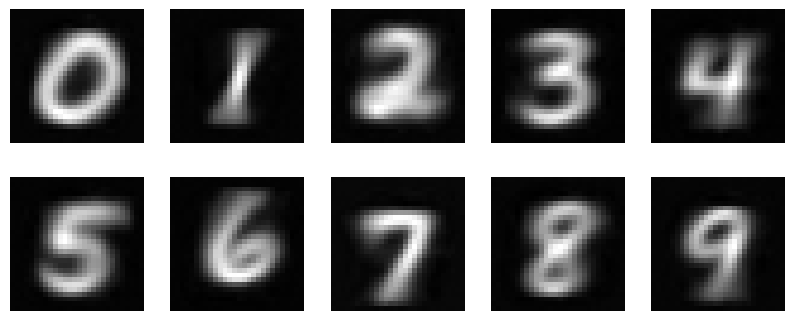

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline

inputs = torch.eye(10)
pred = model(inputs)

fig, axes = plt.subplots(2, 5, figsize=(10, 4))

for i in range(10):
    tensor_pred = pred[i,0]
    axes[i//5, i%5].imshow(tensor_pred.detach().numpy(), cmap="gray")
    axes[i//5, i%5].axis("off")

plt.show()

Unfortunately, this was the prof solution... my solution was: https://www.youtube.com/watch?v=mWMFTfaJaWM&t=7s

# **Es 3**

In [ ]:
class NextNumber(torch.utils.data.Dataset):
    def __init__(self, dataset):
        super().__init__()
        self.dataset = dataset

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        a_data, a_target = self.dataset[idx]
        while a_target == 9:
          idx = (idx + 1) % len (self.dataset)
          a_data, a_target = self.dataset[idx]

        idx = (idx + 1) % len (self.dataset)
        b_data, b_target = self.dataset[idx]
        while b_target != a_target + 1:
          idx = (idx + 1) % len (self.dataset)
          b_data, b_target = self.dataset[idx]

        return a_data, b_data

In [ ]:
class ResidualBlock(torch.nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()

        self.conv1 = torch.nn.Sequential(
            torch.nn.Conv2d(
                in_channels, out_channels,
                kernel_size=3, padding=1
            ),
            torch.nn.BatchNorm2d(out_channels),
            torch.nn.ReLU()
        )

        self.conv2 = torch.nn.Sequential(
            torch.nn.Conv2d(
                out_channels, out_channels,
                kernel_size=3, padding=1
            ),
            torch.nn.BatchNorm2d(out_channels),
        )

        self.downsample = None
        if in_channels != out_channels:
            self.downsample = torch.nn.Sequential(
                torch.nn.Conv2d(
                    in_channels, out_channels,
                    kernel_size=1, stride=1
                ),
                torch.nn.BatchNorm2d(out_channels),
            )

    def forward(self, x):
        y = self.conv1(x)
        y = self.conv2(y)

        if self.downsample is not None:
            out = self.downsample(x) + y
        else:
            out = x + y

        return torch.relu(out)


class ResNet(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.net = torch.nn.Sequential(
            ResidualBlock(1, 16),
            ResidualBlock(16, 32),
            ResidualBlock(32, 64),
            ResidualBlock(64, 64),
            ResidualBlock(64, 64),
            ResidualBlock(64, 64),
            ResidualBlock(64, 32),
            ResidualBlock(32, 16),
            ResidualBlock(16, 1),
        )

    def forward(self, x):
        y = self.net(x)
        return y

ds = NextNumber(train_mnist)
model = ResNet()

for a, b in ds:
    out = model(a.unsqueeze(0))
    print(out.shape)
    break


torch.Size([1, 1, 28, 28])


This is why (1,1,28,28): I'm using BatchNorm2D and it expect a 4D tensor: num_features (int) - C from an expected input of size (N,C,H,W).

In [ ]:
from tqdm import trange, tqdm

batches = 1000
ds = NextNumber(train_mnist)
dl = torch.utils.data.DataLoader(ds, batch_size=32, num_workers=8)
model = ResNet()
loss_fn = torch.nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

model.to("cuda")

for epoch in range(3):
    bar = tqdm(enumerate(dl), total=batches)
    for i, (a, b) in bar:
        a = a.to("cuda")
        b = b.to("cuda")

        optimizer.zero_grad()
        out = model(a)
        loss = loss_fn(out, b)

        loss.backward()
        optimizer.step()

        bar.set_description(f"Loss {loss.item():.4f}")

        if i >= batches:
            break

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
Loss 0.6978: 100%|██████████| 1000/1000 [01:20<00:00, 12.36it/s]


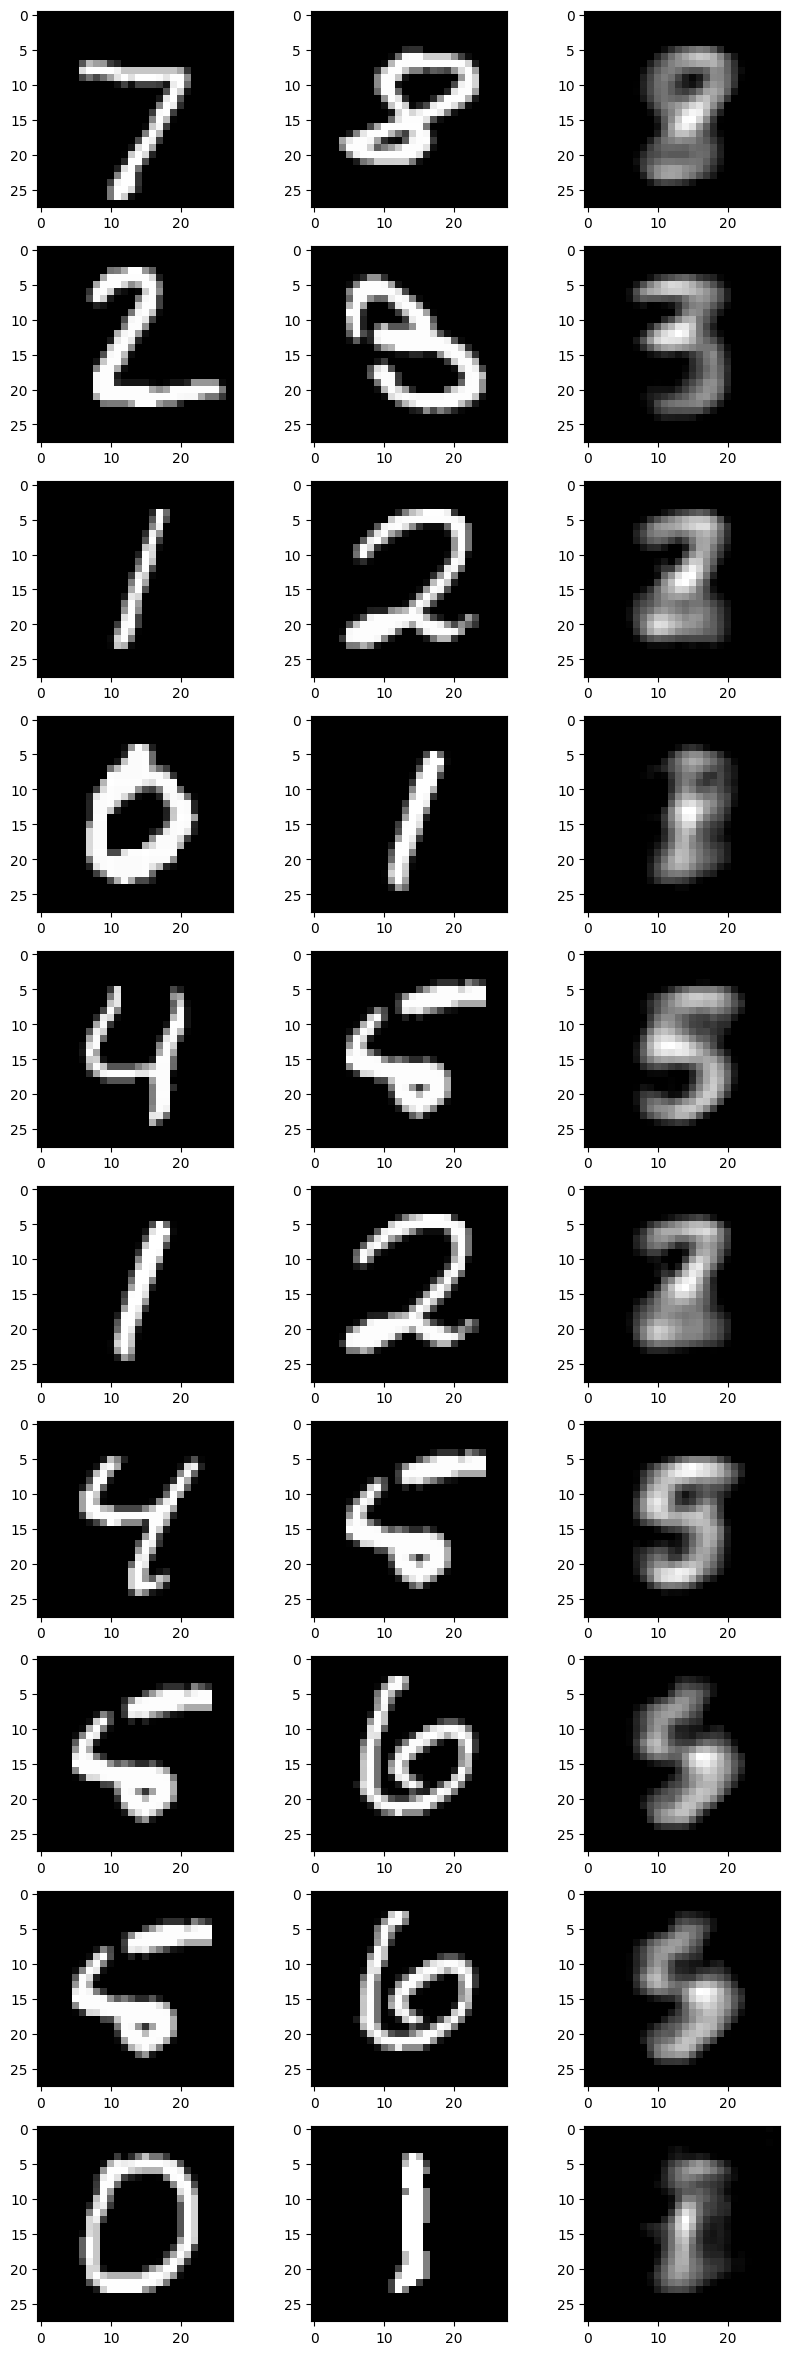

In [ ]:
from matplotlib import pyplot as plt
%matplotlib inline

ds = NextNumber(test_mnist)

fig, axes = plt.subplots(10, 3, figsize=(10, 30))

for i, (a, b) in zip(range(0, 10), ds):
    a = a.to("cuda")
    b = b.to("cuda")
    out = model(a.unsqueeze(0))     #unsqueeze aggiunge una dimensione
    axes[i, 0].imshow(a[0].cpu().numpy(), cmap="gray")

    axes[i, 1].imshow(b[0].cpu().numpy(), cmap="gray")
    axes[i, 2].imshow(out[0, 0].detach().cpu().numpy(), cmap="gray")

plt.show()